# Heston Stochastic Volatility Model

### Model :

We assume that the stock price $S_t$ follows Heston stochastic volatility model under a risk-neutral probability measure,

1. $\frac{dS_t}{S_t} = rdt+\sqrt{X_t}\underbrace{\left(\rho dB_t+\sqrt{1-\rho^2}dW_t\right)}_{dY_t}$, 

where the instantaneous variance follows a CIR process:

2. $dX_t=\kappa(\theta-X_t)dt+\sigma\sqrt{X_t}dB_t$,

and $B_t,\;W_t  \overset{\mathrm{iid}}\sim N(0,t) $ are two independent Standard Brownian Motions.

Parameters of the Heston Stochastic Volatility model:

1. Initial Variance $X_0$.
2. The long-term variance $\theta$, $\lim_{t\to\infty}  X_t=\theta$.
3. The rate of mean-reversion to the long-term variance $\kappa$.
4. The volatility of volatility parameter $\sigma$.
5. The correlation between the two Brownian Motions $\rho$, which seeks to capture the relation between the underlying asset price and the volatility.

Recall that the Cholesky factor of the matrix $ A = \begin{pmatrix}1 & \rho \\\rho & 1\end{pmatrix}\;\text{with}\;-1\leq\rho\leq1,\;\text{is}\; U=\begin{pmatrix}1 & \rho \\0 & \sqrt{1-\rho^2}\end{pmatrix}$.

Given $Z_1,\;Z2\overset{\mathrm{iid}}\sim N(0,1),\;\text{the two normal random variables given by}\;\begin{pmatrix}X_1\\X_2\end{pmatrix}=U^t\begin{pmatrix}Z_1\\Z_2\end{pmatrix}=\begin{pmatrix}Z_1\\\rho Z_1+\sqrt{1-\rho^2}Z_2\end{pmatrix}\sim N(0, A)$,  <br> are normally distributed with variance $1$ and correlation $\rho$.

From the above, it follows that the two Standard Brownian Motions $B_t=Z_1\sqrt{dt}$ and $Y_t=\left(\rho Z_1+\sqrt{1-\rho^2}Z_2\right)\sqrt{dt}$ have correlation $\rho$.

### Theoretical Background

* Computing the implied vols is a straightforward way to see that the lognormal assumption of the underlying asset's distribution and the BS formulas derived based on this assumption are not correct. Several options with different strikes and maturities trade simultaneously. If the lognormal assumption was correct, the implied vols corresponding to all of these options should be equal, but this is not the case, resulting in what is known as the volatility smile. Usually, the implied vol of deep ITM or deep OTM options is higher than the implied vol of ATM options. Particularly for equity options, the volatility smile is skewed, with a common pattern being: $\text{implied vol}_\text{(ITM)}<\text{implied vol}_\text{(ATM)}<\text{implied vol}_\text{(OTM)}$.


* In comparison to the BS model, which assumes constant volatility and lognormal distribution of returns, the Heston model incorporates more realistic and flexible dynamics for both asset prices and volatility. This allows the Heston model to be calibrated to fit the volatility smile observed in the market more accurately than the BS model.The term "fit / capture the volatility smile" refers to the ability of a  model to accurately represent the observed relationship between the implied volatility and the strike prices of options with the same expiry. 

### Monte Carlo Options Pricing and Implied Vols Computation

We use 20,000 Monte Carlo samples to price a European call option with $S_0=100$, $r=0.05$, $T=3/12$ and strike $K=90 : 120$.
We take the CIR parameters to be $\sigma_0=0.2$, $\kappa=3$, $\theta$=0.2 and we adjust $\sigma$ and $\rho$ to be: $\sigma \in \sqrt{2\theta \kappa}\;\text{x}\;\{0.35, 0.75, 1\}$ and $\rho\in \{-0.2, 0, 0.2\}$, so that we get 3 x 3 different option curves.

In simulating the SDEs, we take a step size of $\Delta t =\frac{1}{365}$ and we compare the implied volatility smiles for different $(\sigma, \rho)$ pairs by plotting a (3 x 3) subplot with the horizontal axis being in units of moneyness.

Recall, that the CIR process $dX_t=\kappa(\theta-X_t)dt+\xi\sqrt{X_t}dB_t$ can be simulated using the forward Euler-Maruyama method as: $X_{i+1}=(1-\kappa\Delta t)X_i+\kappa\theta\Delta t + \xi\sqrt{X_i^+}\Delta W_i$, where $X_i^+= max(0, X_i)$.

### Initial Parameters for the SDEs

In [1]:
import numpy as np
import pandas as pd
from math import *
import matplotlib.pyplot as plt

In [2]:
# Initial Parameters
X0 = 0.2
S0 = 100
k = 3
theta = 0.2
ratio = 1
sigma = ratio * np.sqrt(2 * theta * k) # Volatility of volatility parameter
T = 3 / 12
r = 0.05
rho = 0.2
n = round(365 * T)
dt = T / n
M = 20000 # Number of Monte Carlo Samples
disc = np.exp(-r * T) # Discounting Factor
K = np.arange(90, 121)

### Euler-Maruyama method to simulate the SDEs / Underlying Asset Price & Stochastic Volatility Paths

The solution of the GBM SDE is $S_t=S_0e^{\left(r-0.5\sigma^2\right)t+\sigma W_t}$ where $W_t$ is a Standard Brownian Motion under a risk-neutral probability measure. In simulating the GBM paths, we simulate the $ln(S_t)$ of the underlying asset price at each time node and exponentiate at the end.

Also, note that $S_{t+1}=S_te^{(\mu-0.5\sigma^2)\Delta t+\sigma \Delta W_t}$ and so $ln(S_{t+1})=ln(S_t)+(\mu-0.5\sigma^2)\Delta t+\sigma \Delta W_t,\; \Delta W_t \sim N(0, \Delta t) $

In [3]:
# Euler-Maruyama method to simulate the two SDEs
X = np.ones((M, n)) * X0
Y = np.ones((M, n)) * log(S0)
for j in range(1, n):
    # Generate two independent standard brownian motions of shape (M, 1) at each time node
    dW = np.random.normal(0, 1, M) * sqrt(dt)
    dB = np.random.normal(0, 1, M) * sqrt(dt)
    # Simulate the CIR process with the forward Euler - Maruyama method modified to enforce a real  value
    X[:, j] = (1 -k * dt) * X[:, j - 1] + (k * theta * dt) + sigma * np.sqrt(np.maximum(X[:, j - 1], 0)) * dB
    # Since the CIR process simulated by the modified Euler method can hit negative values
    # we use max(X, 0) in the simulation of the underlying price
    # Now, Y_t = ln(S_t)
    Y[:, j] = Y[:, j - 1] + (r - 0.5 * X[:, j - 1]) * dt + np.sqrt(np.maximum(X[:, j - 1], 0)) * (rho * dB + sqrt((1 - rho ** 2)) * dW)

# Exponentiate to get the simulated underlying asset paths
S = np.exp(Y)

#### Simulated Instantaneous Stochastic Variance

Note that because the CIR process of the instantaneous stochastic variance is simulated using the forward Euler method (Stratanovich-type) modified to enforce a real value, it will sometimes hit a negative value.

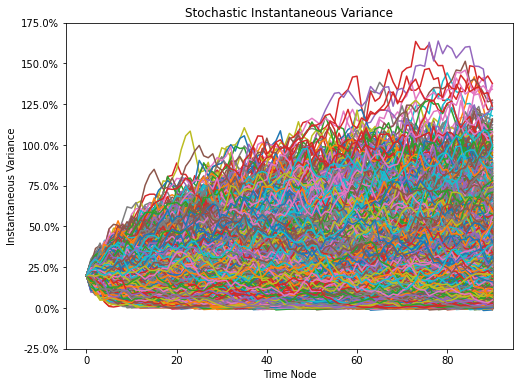

In [4]:
# Plot the simulated instantaneous variance Xt which follows a CIR process
plt.figure(figsize=(8,6))
plt.plot(X.T)
yticks = plt.yticks()[0]
ylabs = [str(100 * tick) + "%" for tick in yticks]
plt.yticks(ticks = yticks, labels = ylabs)
plt.ylabel("Instantaneous Variance")
plt.xlabel("Time Node")
plt.title("Instantaneous Stochastic Variance")
plt.show()

In [5]:
print(f"The instantaneous variance hits negative value an average of {np.sum(X < 0, axis = 1).mean()} times per path")

The instantaneous variance hits negative value an average of 0.1597 times per path


#### Simulated Underlying Asset Price

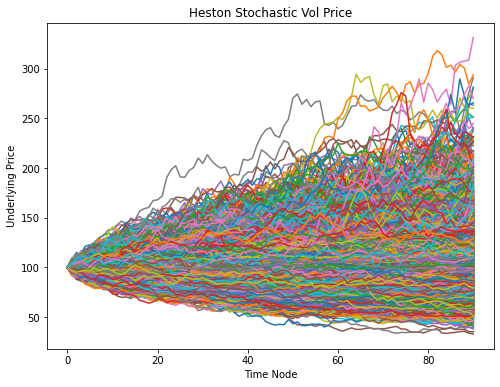

In [6]:
# Plot the simulated udnerlying asset paths using the Heston Stochastic Volatility model
plt.figure(figsize=(8,6))
S = np.exp(Y)
plt.plot(S.T)
plt.ylabel("Underlying Price")
plt.xlabel("Time Node")
plt.title("Heston Stochastic Vol Price")
plt.show()

### Pricing the call options

Under a risk-neutral probability measure $\mathbb{Q}$ in which $W_t\;\text{is a }\; \mathbb{Q}\text{-Brownian Motion}$ the risk-neutral fair price of a European option will be the discounted expectation of its payoff at maturity. Thus, for a European call, the risk-free fair price at time node $t_o=0$ will be:

$C_o=e^{-rT}\mathbb{E}\left[(S_T-K\right)^+]$

When this expectation does not have a closed-form, we approximate it using the Monte Carlo average price, which from the LLN is guaranted to converge in probability to the real expecation: $\frac{1}{M}\Sigma_{i=1}^M\left[(S_{T_i}-K\right)^+]\overset{p}{\to}\mathbb{E}\left[(S_T-K\right)^+]$

### np.meshgrid() for pricing options in the strike space without for loops

Let's discuss briefly the usage of np.meshgrid which can be used as a smart substitute for running for loops.
For example, if we want to price an option for an array of strike prices, instead of using for loops, we can use np.meshgrid() to do it in one-liners. 

np.meshgrid(X, Y) is used to create coordinate grids for vectorized operations when working with multidimensional data. 

Coordinate Pairing: Let $[Z_1, Z_2]$ = np.meshgrid(X_columns, Y_rows)

This creates a grid of coordinates where each point in the grid is formed by a combination of a value from X and a value from Y. 

To achieve that, it generates $\underline {\text{ two, 2D arrays, of the same dimensions:}}\;\text{( Y.size, X.size)}$, where:

* Number of rows = No. elements of Y, each row represents 1 element of Y
* Number of columns = No. elements of X, each column represents 1 element of X

And so, we obtain the following arrays:

1. $Z_1$ of dimension: ( Y.size, X.size), where the 1st row has all the elements of X mapped to the 1st element of Y. The 2nd row has all the elements of X mapped to the second element of Y and so on and so forth, untill the last row which contains all the elements of X mapped to the last element of Y. 


2.  $Z_2$ of dimension: ( Y.size, X.size), where the 1st row has the 1st element of Y mapped to all the elements of X. The 2nd row has the 2nd element of Y mapped to all the elements of X (columns), and so on and so forth, up untill the last row which contains the last element of Y mapped to all the elements of X. $


For example,

In [7]:
X = np.array([[1, 2, 3, 4, 5, 6]])

Y = np.array([90, 100, 110])

Z1, Z2 = np.meshgrid(X, Y)

In [8]:
Z1.shape

(3, 6)

In [9]:
Z1

array([[1, 2, 3, 4, 5, 6],
       [1, 2, 3, 4, 5, 6],
       [1, 2, 3, 4, 5, 6]])

In [10]:
Z2.shape

(3, 6)

In [11]:
Z2

array([[ 90,  90,  90,  90,  90,  90],
       [100, 100, 100, 100, 100, 100],
       [110, 110, 110, 110, 110, 110]])

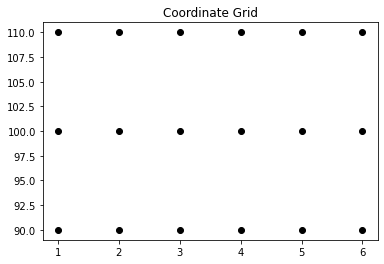

In [12]:
plt.plot(Z1, Z2, marker="o", linestyle="", color="black")
plt.title("Coordinate Grid")
plt.show()

### Pricing the European call option on the strike space with np.meshgrid()

In [13]:
# Exctarct the finishing values
S_terminal = S[:, -1]
S_terminal.shape
# Create the grid: Strikes x MC Terminal Values
S_last, K_grid = np.meshgrid(S_terminal, K)

In [14]:
S_last.shape

(31, 20000)

In [15]:
K_grid.shape

(31, 20000)

The 1st array of the grid is an array of 31 rows, each for a unique strike price. Each row contains 20,000 terminal asset values, 1 price per each Monte Carlo sample path.


The 2nd array of the grid is an array of 31 rows, each for a unique strike price. Each row contains 1 strike price replicated 20,000 times, 1 time per each Monte Carlo sample path.

In [16]:
S_last

array([[111.87875228,  88.5424997 ,  98.07733138, ...,  95.57864175,
         79.32803892, 109.33969267],
       [111.87875228,  88.5424997 ,  98.07733138, ...,  95.57864175,
         79.32803892, 109.33969267],
       [111.87875228,  88.5424997 ,  98.07733138, ...,  95.57864175,
         79.32803892, 109.33969267],
       ...,
       [111.87875228,  88.5424997 ,  98.07733138, ...,  95.57864175,
         79.32803892, 109.33969267],
       [111.87875228,  88.5424997 ,  98.07733138, ...,  95.57864175,
         79.32803892, 109.33969267],
       [111.87875228,  88.5424997 ,  98.07733138, ...,  95.57864175,
         79.32803892, 109.33969267]])

In [17]:
K_grid

array([[ 90,  90,  90, ...,  90,  90,  90],
       [ 91,  91,  91, ...,  91,  91,  91],
       [ 92,  92,  92, ...,  92,  92,  92],
       ...,
       [118, 118, 118, ..., 118, 118, 118],
       [119, 119, 119, ..., 119, 119, 119],
       [120, 120, 120, ..., 120, 120, 120]])

In [18]:
# Compute the European call value as the discounted expectation of the final payoff
final_payoff = np.maximum(S_last - K_grid, 0) # Element-wise maximum
call_prices = disc * (final_payoff.mean(axis = 1))

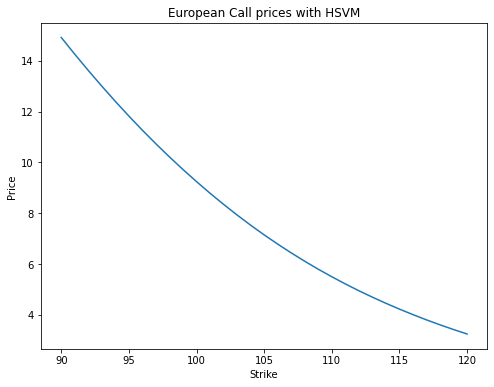

In [19]:
# Call prices on the Strikes space
plt.figure(figsize=(8, 6))
plt.plot(K, call_prices)
plt.xlabel("Strike")
plt.ylabel("Price")
plt.title("European Call prices with HSVM")
plt.show()

### Pricing varying option curves according to different HSVM calibrations

In [35]:
rho_list = [-0.2, 0, 0.2]
sigma_list = [sqrt( 2 * theta * k) *x for x in [0.35, 0.75, 1]]
# Empty list to store the call prices
call_prices = []
for sigma in sigma_list:
    for rho in rho_list:
        # Euler-Maruyama methd to simulate the two SDEs
        X = np.ones((M, n)) * X0
        Y = np.ones((M, n)) * log(S0)
        for j in range(1, n):
            # Generate two independent standard brownian motions of shape (M, 1) at each time node
            dW = np.random.normal(0, 1, M) * sqrt(dt)
            dB = np.random.normal(0, 1, M) * sqrt(dt)
            # Simulate the CIR process with the forward Euler - Maruyama method modified to enforce a real  value
            X[:, j] = (1 -k * dt) * X[:, j - 1] + (k * theta * dt) + sigma * np.sqrt(np.maximum(X[:, j - 1], 0)) * dB
            # Since the CIR process simulated by the modified Euler method can hit negative values
            # we use max(X, 0) in the simulation of the underlying price
            # Now, Y_t = ln(S_t)
            Y[:, j] = Y[:, j - 1] + (r - 0.5 * X[:, j - 1]) * dt + np.sqrt(np.maximum(X[:, j - 1], 0)) * (rho * dB + sqrt((1 - rho ** 2)) * dW)

        # Exponentiate to get the simulated underlying asset paths
        S = np.exp(Y)
        # Extract the finishing values
        S_terminal = S[:, -1]
        # Create the grid: Strikes x MC Terminal Values
        S_last, K_grid = np.meshgrid(S_terminal, K)
        # Compute the final payoff for each  Strike price and Monte Carlo sample (element-wise maximum)
        final_payoff = np.maximum(S_last - K_grid, 0)
        # Compute the call price as the discounted expectation of the final payoff
        call_price = disc * (final_payoff.mean(axis=1))
        call_prices.append(call_price)

In [36]:
np.array(call_prices).shape

(9, 31)

In [37]:
# Extarct the call prices and tranform them in a df
calls = pd.DataFrame(np.array(call_prices).T, index=K)
calls.index.rename("Strike", inplace=True)
moneyness = (S0 - K) / K

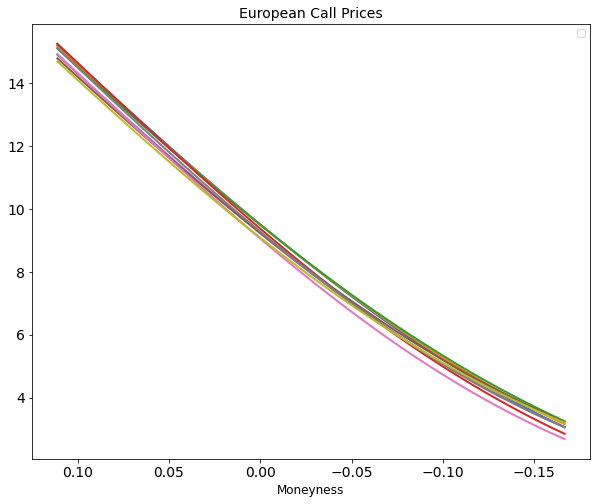

In [38]:
calls.set_index(moneyness).plot(figsize=(10, 8 ), fontsize=14, linewidth=2)
plt.legend("")
plt.title("European Call Prices", fontsize=14)
plt.xlabel("Moneyness", fontsize=12)
plt.gca().invert_xaxis()
plt.show()

### Volatility Smiles of the calls for varying HSVM calibrations

In [39]:
from py_vollib_vectorized.implied_volatility import vectorized_implied_volatility as imp_vol_bs

In [42]:
# Empty dataframe to store the volatility smiles
vol_smiles = pd.DataFrame()
for i in range(calls.shape[1]):
    vol_smile = imp_vol_bs(calls.iloc[:, i], S0, K, T, r, q=0, flag="c")
    vol_smiles = pd.concat([vol_smiles, vol_smile], axis = 1)
vol_smiles.set_index(moneyness, inplace=True)
vol_smiles.index.rename("Moneyness", inplace=True)

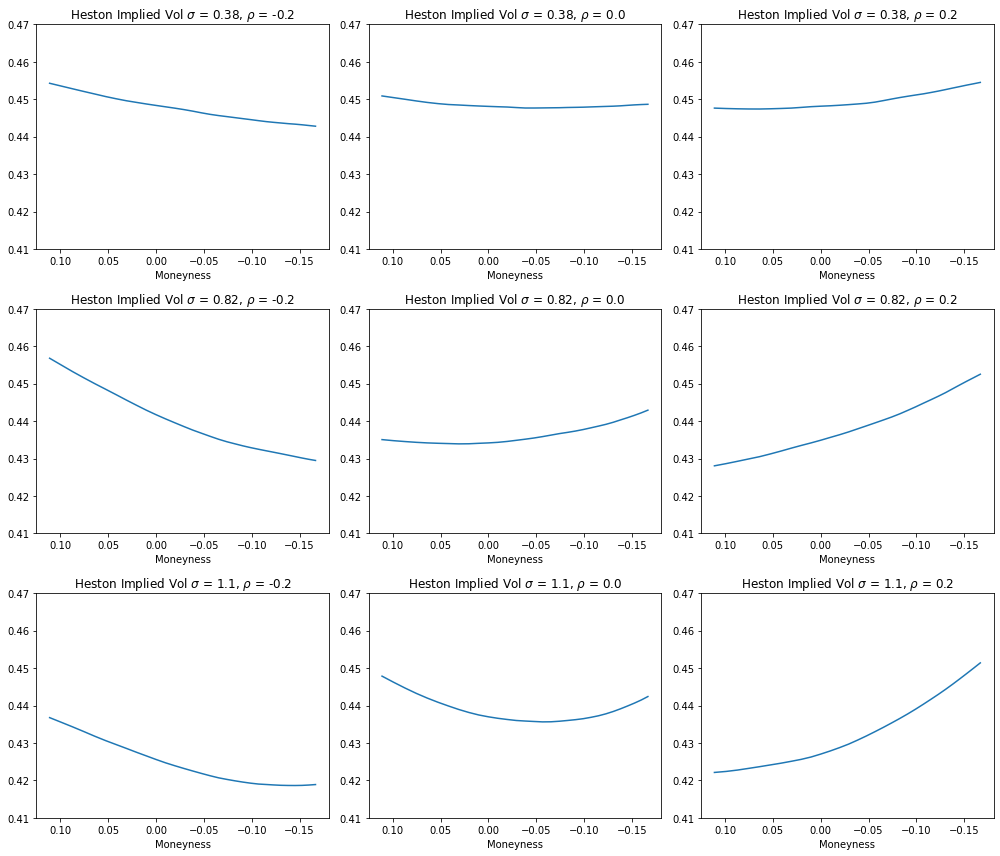

In [43]:
# Plot the Volatility Smiles
fig, axs = plt.subplots(3, 3, figsize=(14, 12))
axs = axs.flatten()
sigma_param = np.tile(np.array(sigma_list).reshape(-1, 1), 3).flatten().round(2)
rho_param = np.tile(np.array(rho_list), 3)
for i, ax in enumerate(axs):
    vol_smiles.iloc[:, i].plot(ax=ax)
    ax.set_ylim(0.41, 0.47)
    ax.invert_xaxis()
    ax.set_title("Heston Implied Vol " +  r"$\sigma$ = " + str(sigma_param[i]) + r", $\rho$ = " + str(rho_param[i]))

plt.tight_layout()
plt.show()

### Effect of the HSVM calibration on capturing the Volatility Smile

**1. <u>Effect of the vol-of-vol parameter $\sigma$ on the Smile**

 The vol-of-vol parameter controls the overall level of the smile.


**2. <u>Effect of the correlation parameter $\rho$ on the Smile**
    
 The correlation parameter controls the smile’s skew: when $\rho  < 0$, the smile is left-skewed. When $ \rho > 0$, the smile is right-skewed. For $\rho < 0$, we establish a negative relationship between the asset returns and their volatility, which is known as the volatility leverage effect. The volatility leverage effect refers to the usually observed phenomenon that the returns on an underlying asset are negatively correlated with the asset’s volatility, which in terms of equity options means that as volatility rises, the stock price falls. Thus, $ \rho <0$ for equities re-creates the crash-o-phobia effect that drives the premium in options, and leads to a right-skewed volatility smile with deep ITM options being priced with higher implied volatilities compared to ATM and OTM options.